In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import bisect
from scipy.stats import beta
import math

from mpl_toolkits.mplot3d import Axes3D

In [3]:
def timer(f):
    
    def countTime(*args, **kwargs):
        print("Start simulating...")
        s = time.time()
        res = f(*args, **kwargs)
        e = time.time()
        print("End simulating.")
        print("Processed in %f seconds." %(e-s))
        return res
    
    return countTime

In [21]:
def vecfunc(f):
    return np.frompyfunc(f,1,1)

In [4]:
@timer
def monteCarlo(points: int, mult: int, weights: np.array, steps: int) -> np.array:
    """
    weights为权重向量，最小值应为0，最大值应为1
    """
    dimension = len(weights)
    alpha = np.ones(dimension)*mult/2
    rvec = np.random.dirichlet(alpha, size = points)
    col = np.dot(rvec, weights)
    return col

In [5]:
points = 10**6
mult = 1
weights = np.array([0, 0.3, 1])
steps = 10**6

Start simulating...
End simulating.
Processed in 0.601399 seconds.


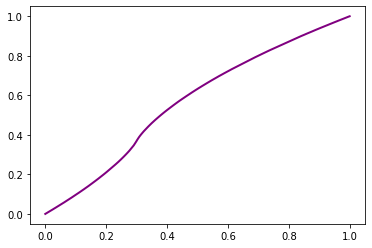

In [6]:
col = monteCarlo(points,mult,weights,steps)
col.sort()
x = np.linspace(0, 1, steps)
y = col
plt.plot(y, x, ls = "-", lw = 2, color = "purple")
plt.show()

In [24]:
def operator(tsteps:int, xsteps: int, lam: float, m: int, n: int, f): # Integral operator, use Simpson formula here
    # Convert CDF to integral core
    x = np.dot(np.linspace(0,1,2*xsteps+1).reshape(2*xsteps+1,1),np.ones(tsteps+1).reshape(1,tsteps+1))
    y = np.dot(np.ones(2*xsteps+1).reshape(2*xsteps+1,1),np.linspace(0,1,tsteps+1).reshape(1,tsteps+1))
    intCore = (y-lam*x)/(1-x)
    intCore[np.isnan(intCore)] = lam
    intCore[np.isinf(intCore)] = 1
    intCore = f(intCore)
    """
    fig = plt.figure()
    ax = Axes3D(fig)
    X, Y = np.meshgrid(np.linspace(0,1,tsteps+1),np.linspace(0,1,2*xsteps+1))
    plt.xlabel("x")
    plt.ylabel("y")
    ax.plot_surface(X,Y,intCore,rstride=1,cstride=1,cmap="rainbow")
    """
    # Create Beta density function
    betaFunc = lambda x: beta.pdf(x,m/2,n/2)
    betaFunc = np.frompyfunc(betaFunc,1,1)
    betaDens = np.linspace(0,1,2*xsteps+1)
    betaDens = betaFunc(betaDens)
    betaDens[0] = 0
    betaDens[-1] = 0
    
    # Simpson formula
    betaDens[2:2*xsteps:2] *= 2
    betaDens[1:2*xsteps:2] *= 4
    betaDens /= 6*xsteps
    
    # Integrate
    return np.dot(betaDens,intCore)

In [25]:
@vecfunc
def cdf(x: float) -> float: # CDF of S_n-1 # cdf of lambda = (0,1), m = (1,1)
    return math.asin(2*min(1,max(0,x))-1)/math.pi+0.5

/tmp/ipykernel_302/1457796757.py:5: RuntimeWarning: divide by zero encountered in true_divide
  intCore = (y-lam*x)/(1-x)
/tmp/ipykernel_302/1457796757.py:5: RuntimeWarning: invalid value encountered in true_divide
  intCore = (y-lam*x)/(1-x)


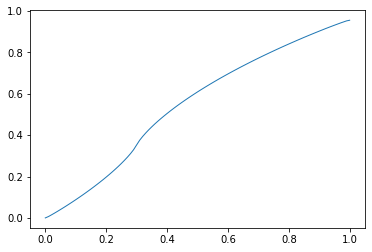

In [27]:
xsteps, tsteps = 10**2, 10**2
lam = 0.3
m, n = 1, 2

x = np.linspace(0,1,tsteps+1)
y = operator(tsteps,xsteps,lam,m,n,cdf)
plt.plot(x,y,ls="-",lw=1)

In [13]:
print(y)

[0.0 0.008894975491517446 0.0180583169249122 0.02735540276506762
 0.03677766358766829 0.04632475472799419 0.055999093501468436
 0.06580480269457555 0.07574693053797851 0.08583129851164617
 0.09606473668773376 0.10645484955970227 0.11701009176239416
 0.1277401386172203 0.1386558050293638 0.14976924669356448
 0.1610944776202205 0.17264749372723176 0.1844467276081208
 0.19651392494349257 0.20887477423103545 0.2215600977858042
 0.23460787016454837 0.24806562586466277 0.26199461815043323
 0.27647715365595177 0.2916291650719086 0.307626361266898
 0.3247681309013634 0.3436865027417928 0.36736485609226155
 0.3909698938763971 0.4097205897762844 0.42662374859021795
 0.44232442514400516 0.45713119607012337 0.4712265825136272
 0.484731768782828 0.49773317487710417 0.510295928106059
 0.5224705635085461 0.5342974839825738 0.545810081174661
 0.5570360680516745 0.5679989126276815 0.5787186798025615
 0.5892129783743646 0.5994970676508723 0.6095843404997668
 0.6194869423880188 0.6292156074652712 0.63877